# $sin(x)$

This notebook shows how you can use a Bayesian Neural Network to estimate a noisy $sin(x)$ with limited data.

In [1]:
%matplotlib inline

In [2]:
import tqdm
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from bnn import bayesian_model, CDropout

In [3]:
def plot_particles(model, x, y, n_particles=100, use_predicted_std=True):
    x_ = x.repeat(n_particles, 1, 1)
    out = model(x_)
    out, log_std = out.split([y.shape[1], y.shape[1]], dim=-1)
    if use_predicted_std:
        out = out + log_std.exp() * torch.randn_like(out)
    out = out.detach().numpy()
    
    x = x.numpy()
    y = y.detach().numpy()
    
    plt.figure(figsize=(12, 6))
    samples_plt, = plt.plot(
        X.numpy(), Y.numpy(),
        "rs", ms=4, label="Sampled points")

    y_plt, = plt.plot(x, y, "r--", label="Ground truth")

    for i in range(n_particles):
        particle_plt, = plt.plot(x, out[i], "b-",
                                 alpha=1.0 / 15, label="Particle estimate")

    plt.axis([-4, 4, -2, 2])
    plt.legend(handles=[samples_plt, y_plt, particle_plt])
    plt.show()
    

def plot_variance(model, x, y, n_particles=100, use_predicted_std=True):
    x_ = x.repeat(n_particles, 1, 1)
    out = model(x_)
    out, log_std = out.split([y.shape[1], y.shape[1]], dim=-1)
    if use_predicted_std:
        out = out + log_std.exp() * torch.randn_like(out)
    
    mu = out.mean(dim=0).detach().numpy()
    std = out.std(dim=0).detach().numpy()
    
    x = x.numpy()
    y = y.detach().numpy()
    
    plt.figure(figsize=(12, 6))
    samples_plt, = plt.plot(
        X.numpy(), Y.numpy(),
        "rs", ms=4, label="Sampled points")

    y_plt, = plt.plot(x, y, "r--", label="Ground truth")
    mu_plt, = plt.plot(x, mu, "k-", label="Mean estimate")
    
    for i in range(1, 4):
        std_plt = plt.gca().fill_between(
            x.flat, (mu - i * std).flat, (mu + i * std).flat,
            color="#dddddd", alpha=1.0/i, label="Confidence")

    plt.axis([-4, 4, -2, 2])
    plt.legend(handles=[samples_plt, y_plt, mu_plt, std_plt])
    plt.show()

## Dataset

In [4]:
def secret_function(x, noise=0.0):
    return x.sin() + noise * torch.randn_like(x)

In [5]:
# Training data with noise
X = 8 * torch.rand(20, 1) - 4
Y = secret_function(X, noise=1e-1)

# Test data without noise
x = torch.linspace(-4, 4).reshape(-1, 1)
y = secret_function(x)

## Initialize model

In [6]:
model = bayesian_model(X.shape[1], 2 * Y.shape[1], [200, 200])

In [7]:
model

BSequential(
  (fc_0): Linear(in_features=1, out_features=200, bias=True)
  (drop_0): CDropout(temperature=0.10000000149011612)
  (nonlin_0): ReLU()
  (fc_1): Linear(in_features=200, out_features=200, bias=True)
  (drop_1): CDropout(temperature=0.10000000149011612)
  (nonlin_1): ReLU()
  (fc_out): Linear(in_features=200, out_features=2, bias=True)
)

## Before optimization

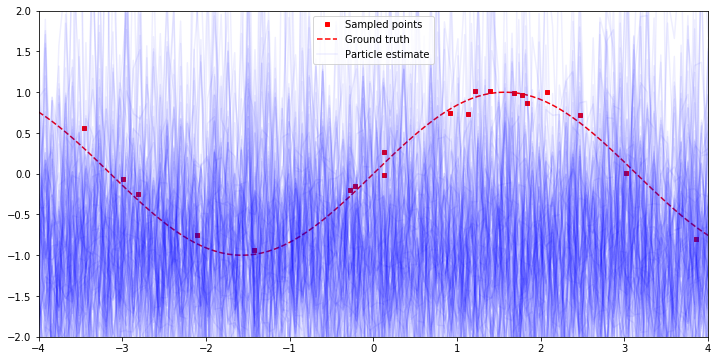

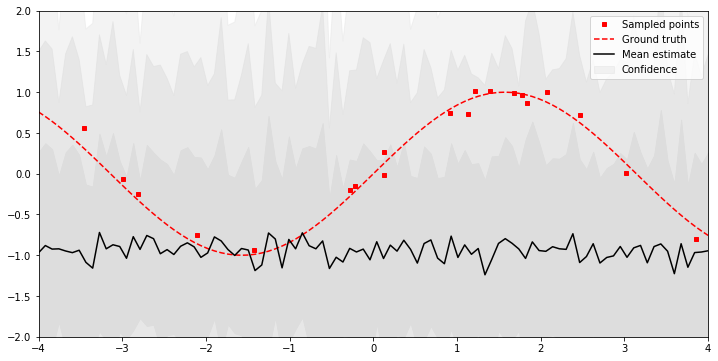

In [8]:
plot_particles(model, x, y)
plot_variance(model, x, y)

## Optimize

In [9]:
def gaussian_log_likelihood(targets, pred_means, pred_stds=None):
    deltas = pred_means - targets
    if pred_stds is not None:
        lml = -((deltas / pred_stds)**2).sum(-1) * 0.5 \
              - pred_stds.log().sum(-1) \
              - np.log(2 * np.pi) * 0.5
    else:
        lml = -(deltas**2).sum(-1) * 0.5

    return lml

In [10]:
opt = torch.optim.Adam(p for p in model.parameters() if p.requires_grad)

In [11]:
pbar = tqdm.tnrange(2500)
for i in pbar:
    opt.zero_grad()
    output = model(X, resample=True)
    mean, log_std = output.split([Y.shape[1], Y.shape[1]], dim=-1)
    loss = (-gaussian_log_likelihood(Y, mean, log_std.exp())
            + 1e-2 * model.regularization()).mean()
    pbar.set_postfix({"loss": loss.detach().numpy()})
    loss.backward()
    opt.step()

## After optimization

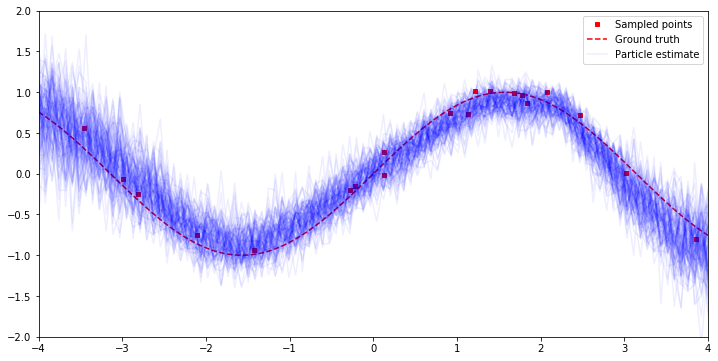

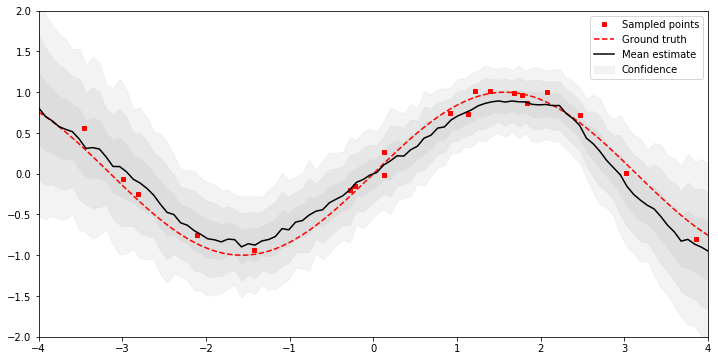

In [12]:
plot_particles(model, x, y)
plot_variance(model, x, y)